In [1]:
import numpy as np
import pandas as pd
import os, pickle

from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Adosrbate

In [2]:
mapping = pd.read_pickle('/home/jovyan/shared-scratch/jhoon/ocp2023/oc20dense_metadata/oc20dense_mapping.pkl')

In [3]:
def classify_adsorbate(adsorbate):
    """
    Classify adsorbates based on the number of C and N atoms.
    """
    c_count = adsorbate.count('C')
    n_count = adsorbate.count('N')

    # if n_count == 2:
    #     return 'N2'   # With 2 N
    if n_count >= 1:
        return 'N'   # With 1 N
    elif c_count == 2:
        return 'C2'   # With 2 C
    elif c_count == 1:
        return 'C1'   # With 1 C
    elif c_count == 0 and n_count == 0:
        return 'O&H'  # Without C & N
    else:
        return 'Other' # Other compositions

## Encoder

In [24]:
enhancement = "ssl-combined"
model = "gnoc"
file_mapping = {"vanilla": f"emb-rebase3-vanilla-catberta_1223_1537-eval-{model}-strc.pkl",
                "ca": f"emb-rebase3-da-catberta_1224_1518-eval-{model}-strc.pkl",
                "gap": f"emb-rebase-gap-catberta_1221_2208-eval-{model}-strc.pkl",
                "ca-gap": f"emb-rebase-da-gap-catberta_1226_0542-eval-{model}-strc.pkl",
                "ssl-oc20":f"emb-ssl-oc20-eqv2_1204_2048-eval-{model}-strc.pkl",
                'ssl-combined':f"emb-ssl-combined-eqv2_1207_1531-eval-{model}-strc.pkl",
                "roberta" :"emb-roberta-base-eval-gnoc-strc.pkl"
}
emb_file = file_mapping[enhancement]

In [25]:
data_path = f'/home/jovyan/shared-scratch/jhoon/ocp2023/clip_data/oc20dense_eval_{model}_relaxed.pkl'
emb_path = f"/home/jovyan/shared-scratch/jhoon/ocp2023/results/encoder_embedding/{emb_file}" #'/home/jovyan/shared-scratch/jhoon/ocp2023/results/encoder_embedding/catbert_ft_1201_0522_eval_escn-emb.pkl'
perplexity = 30

In [26]:
df_data = pd.read_pickle(data_path)
dict_emb = pd.read_pickle(emb_path) # change to dataframes

# change dict_emb (dictionary) to pandas dataframe with column name of 'emb'
df_emb = pd.DataFrame(list(dict_emb.items()), columns=['id', 'emb'])

# remove 'text', 'chg_emb' columns in df_data
sid_list, ads_list = [], []
for i in range(len(df_data)):
    sid = df_data['id'].iloc[i].split('_')[0]
    ads = mapping[int(sid)]['adsorbate']
    sid_list.append(sid)
    ads_list.append(ads)
df_data['sid'] = sid_list
df_data['ads'] = ads_list
df_data['category'] = df_data['ads'].apply(classify_adsorbate)
df_data = df_data.drop(columns=['text', 'sid', 'ads', 'chg_emb'])

# combine df_data and df_emb along with 'id' column
df = pd.merge(df_data, df_emb, on='id') 
df

,id,target,category,emb
0,85487_-1,-0.559899,C1,"[0.041278016, -0.13417321, -0.35372427, 0.8157..."
1,39118_110,-1.130786,O&H,"[-0.28682065, -0.44723496, -0.13362113, -0.871..."
2,2797_-1,-1.337591,C1,"[-0.6321089, -0.14210434, 0.25876504, 0.021018..."
3,64221_170,0.885938,C1,"[-0.25964615, -0.033809375, -0.14045128, -0.21..."
4,44017_160,-2.090978,C1,"[0.5638168, 0.24399866, -0.09020624, 0.3083757..."
...,...,...,...,...
11503,55536_186,-2.349694,C1,"[0.18084207, -0.04772223, -0.088915125, 0.3097..."
11504,84011_298,-2.974431,C2,"[-0.19021106, 0.9235767, -0.14598824, -0.43360..."
11505,64542_152,0.239314,C1,"[0.5720266, -0.10533342, -0.45970497, 0.187360..."
11506,71806_221,-1.262554,C1,"[0.18264472, 0.22696045, -0.009182213, 0.10234..."


In [27]:
category_counts = df_data['category'].value_counts()
category_counts

C2     4892
C1     4507
O&H    1483
N       626
Name: category, dtype: int64

In [28]:
# Extract embeddings and targets
embeddings = np.array(df['emb'].tolist())
targets = df['category'].values

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Create a new DataFrame for t-SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['category'] = targets

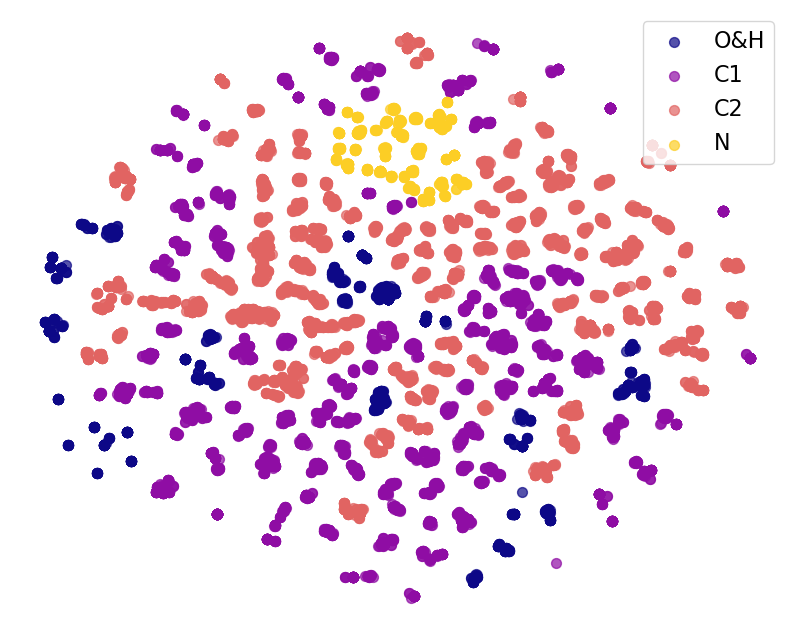

In [29]:
# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(10, 8))

# Define categories and their corresponding colors from the 'tab10' colormap
categories = ['O&H', 'C1', 'C2', 'N']
colors = plt.cm.plasma(np.linspace(0, 0.9, len(categories)))

# Scatter plot for each category
for category, color in zip(categories, colors):
    subset = tsne_df[tsne_df['category'] == category]
    ax.scatter(subset['tsne1'], subset['tsne2'], c=[color], label=category, s=50, alpha=0.7)


# Adding the legend
ax.legend(fontsize=16, loc='upper right')

# Remove box frame, ticks, and labels
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
fig.savefig(f"ads-class/{model}-{enhancement}-p{perplexity}.png", dpi=300, bbox_inches='tight')

## Equiformer Embedding

In [203]:
model = 'gnoc'
emb_dir_mappipng = {"gnoc": "2023-12-28-18-37-52-eq31-maxpool-gnoc-eval",
                    "scn": "2023-12-28-21-41-20-eq31-maxpool-scn-eval",
                    "escn": "2023-12-08-18-54-56-eq31-maxpool-escn-eval"}

label_dir_mapping = {"gnoc": "2023-12-03-03-33-20-eqv2-gnoc-eval",
                    "scn": "2023-12-03-07-15-12-eqv2-scn-eval",
                    "escn": "2023-12-03-07-25-52-eqv2-escn-eval"}

emb_dir = emb_dir_mappipng[model]
label_dir = label_dir_mapping[model]

In [204]:
perplexity=100

In [205]:
emb_path = f"/home/jovyan/shared-scratch/jhoon/ocp2023/results/embedding/results/{emb_dir}/s2ef_predictions.npz"
emb_data = np.load(emb_path)

In [206]:
data_path = f"/home/jovyan/shared-scratch/jhoon/ocp2023/clip_data/oc20dense_eval_{model}_relaxed.pkl"
df_data = pd.read_pickle(data_path)

In [207]:
# change dict_emb (dictionary) to pandas dataframe with column name of 'emb'
# df_emb = pd.DataFrame({
#     'ids': emb_data['ids'],
#     'energy': emb_data['energy']
# })

ids = emb_data['ids']
energies = emb_data['energy']
df_emb = pd.DataFrame({
    'id': ids,
    'embedding': list(map(np.array, energies))
})
# Creating a list of DataFrames, one for each id
# df_emb = [pd.DataFrame({'id': id, 'energy': energies[i, :]}) for i, id in enumerate(ids)]

# remove 'text', 'chg_emb' columns in df_data
sid_list, ads_list = [], []
for i in range(len(df_data)):
    sid = df_data['id'].iloc[i].split('_')[0]
    ads = mapping[int(sid)]['adsorbate']
    sid_list.append(sid)
    ads_list.append(ads)
df_data['sid'] = sid_list
df_data['ads'] = ads_list
df_data['category'] = df_data['ads'].apply(classify_adsorbate)
df_data = df_data.drop(columns=['text', 'sid', 'ads', 'chg_emb'])


# combine df_data and df_emb along with 'id' column
df = pd.merge(df_data, df_emb, on='id') 
df

,id,target,category,embedding
0,85487_-1,-0.559899,C1,"[-0.4143, 1.826, 0.8164, 7.125, -0.0447, 5.047..."
1,39118_110,-1.130786,O&H,"[0.677, 4.445, -0.523, 2.652, 0.7417, 4.336, 1..."
2,2797_-1,-1.337591,C1,"[-0.0277, 3.582, -0.2208, 7.496, 1.466, 3.633,..."
3,64221_170,0.885938,C1,"[1.11, 4.48, 0.6533, 7.348, 1.227, 7.26, 2.156..."
4,44017_160,-2.090978,C1,"[-0.006176, 3.135, -0.7144, 6.727, 1.003, -1.6..."
...,...,...,...,...
11503,55536_186,-2.349694,C1,"[0.535, 2.639, -0.1702, 7.24, -0.04846, 0.585,..."
11504,84011_298,-2.974431,C2,"[-0.09546, 1.281, -0.711, 6.582, -0.0691, -1.1..."
11505,64542_152,0.239314,C1,"[0.9966, 4.652, 0.4302, 7.027, 0.8047, 5.367, ..."
11506,71806_221,-1.262554,C1,"[0.1306, 2.635, -0.592, 7.15, -0.1045, -0.1831..."


In [208]:
category_counts = df_data['category'].value_counts()

category_counts

C2     4892
C1     4507
O&H    1483
N       626
Name: category, dtype: int64

In [209]:
# Extract embeddings and targets
embeddings = np.stack(df['embedding'].values) #df['embedding']
targets = df['category'].values

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Create a new DataFrame for t-SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['category'] = targets

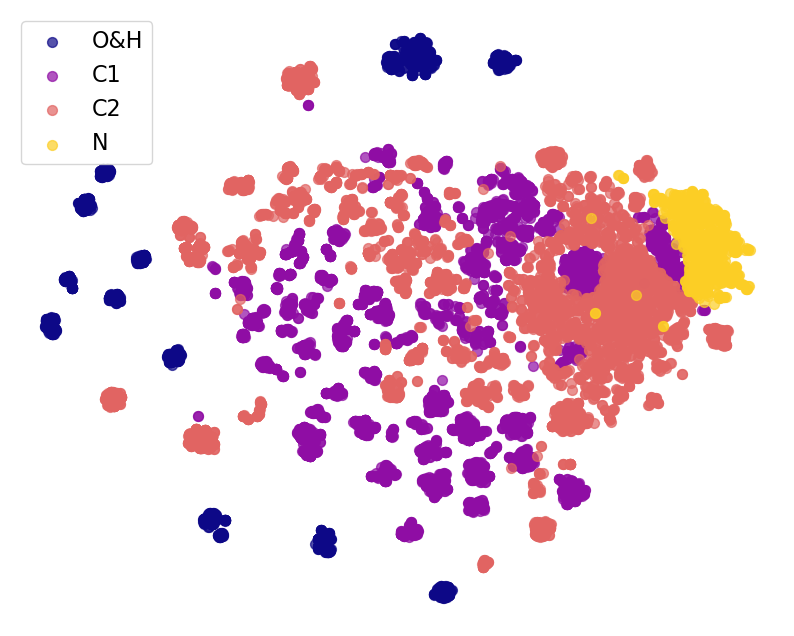

In [210]:
# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(10, 8))

# Define categories and their corresponding colors from the 'tab10' colormap
categories = ['O&H', 'C1', 'C2', 'N']
colors = plt.cm.plasma(np.linspace(0, 0.9, len(categories)))

# Scatter plot for each category
for category, color in zip(categories, colors):
    subset = tsne_df[tsne_df['category'] == category]
    ax.scatter(subset['tsne1'], subset['tsne2'], c=[color], label=category, s=50, alpha=0.7)


# Adding the legend
ax.legend(fontsize=16)

# Remove box frame, ticks, and labels
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

# save tsne plot
fig.savefig(f"ads-class/eq-emb-{model}-p{perplexity}.png", dpi=300, bbox_inches='tight')

# Catalyst

In [73]:
def determine_catalyst(catalyst, target_elements=['Zr', 'Ni', 'Al']):
    """
    Determine whether target elements are included in the catalyst.

    Parameters:
    catalyst (str): The catalyst string to be evaluated.

    Returns:
    str: target elements if the respective element is in the catalyst,
         otherwise return None.
    """
    
    for element in target_elements:
        if element in catalyst:
            return element
    return "Others"

## Encoder

In [118]:
enhancement = "ssl-oc20"
model = "gnoc"
file_mapping = {"vanilla": f"emb-rebase3-vanilla-catberta_1223_1537-eval-{model}-strc.pkl",
                "ca": f"emb-rebase3-da-catberta_1224_1518-eval-{model}-strc.pkl",
                "gap": f"emb-rebase-gap-catberta_1221_2208-eval-{model}-strc.pkl",
                "ca-gap": f"emb-rebase-da-gap-catberta_1226_0542-eval-{model}-strc.pkl",
                "ssl-oc20":f"emb-ssl-oc20-eqv2_1204_2048-eval-{model}-strc.pkl"
}
emb_file = file_mapping[enhancement]

In [119]:
data_path = f'/home/jovyan/shared-scratch/jhoon/ocp2023/clip_data/oc20dense_eval_{model}_relaxed.pkl'
emb_path = f"/home/jovyan/shared-scratch/jhoon/ocp2023/results/encoder_embedding/{emb_file}" #'/home/jovyan/shared-scratch/jhoon/ocp2023/results/encoder_embedding/catbert_ft_1201_0522_eval_escn-emb.pkl'
perplexity = 30

In [120]:
df_data = pd.read_pickle(data_path)
dict_emb = pd.read_pickle(emb_path) # change to dataframes

# change dict_emb (dictionary) to pandas dataframe with column name of 'emb'
df_emb = pd.DataFrame(list(dict_emb.items()), columns=['id', 'emb'])

# split 'id' column into 'sid' and 'frame'
df_data['sid'] = df_data['id'].apply(lambda x: x.split('_')[0])
df_data['frame'] = df_data['id'].apply(lambda x: x.split('_')[1])

# check whether there are duplicated sids
duplicate_sids_count = df_data['sid'].duplicated().sum()
print('duplicate: ', duplicate_sids_count)

# Extracting 'catalyst' from 'text' using apply()
df_data['catalyst'] = df_data['text'].apply(lambda x: x.split('</s>')[1].split(' (')[0])
df_data['category'] = df_data['catalyst'].apply(determine_catalyst)


df_data = df_data.drop(columns=['text', 'chg_emb', 'sid', 'frame', 'catalyst'])

df = pd.merge(df_data, df_emb, on='id') 
df

duplicate:  0


,id,target,category,emb
0,85487_-1,-0.559899,Others,"[-0.549058, -1.1354752, -0.40167862, -0.992077..."
1,39118_110,-1.130786,Zr,"[-0.3370221, -0.7792724, 0.3067538, 0.12698187..."
2,2797_-1,-1.337591,Others,"[-0.19053055, -1.0866988, 0.033530287, 0.15730..."
3,64221_170,0.885938,Others,"[0.4124212, 0.07864204, 0.35846403, 1.1141418,..."
4,44017_160,-2.090978,Ni,"[0.24780147, -0.075886846, 0.7399495, -0.39893..."
...,...,...,...,...
11503,55536_186,-2.349694,Ni,"[0.3134737, -0.03943238, 0.09326017, -0.285356..."
11504,84011_298,-2.974431,Zr,"[0.2045172, 0.26007923, -0.70438135, -0.498060..."
11505,64542_152,0.239314,Others,"[-0.22459579, 0.14825387, -0.6137538, 1.087228..."
11506,71806_221,-1.262554,Ni,"[0.24549098, -0.1700388, -0.15096143, -0.40936..."


In [121]:
category_counts = df_data['category'].value_counts()

category_counts

Others    6883
Zr        2358
Ni        2026
Al         241
Name: category, dtype: int64

In [122]:
# Extract embeddings and targets
embeddings = np.array(df['emb'].tolist())
targets = df['category'].values

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Create a new DataFrame for t-SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['category'] = targets

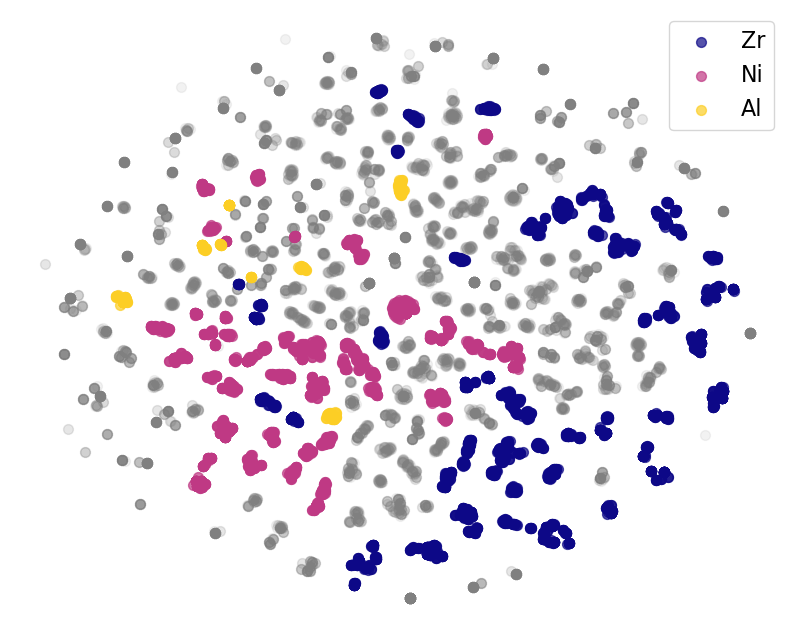

In [123]:
# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(10, 8))

# Define categories and their corresponding colors from the 'tab10' colormap
categories = ['Zr', 'Ni', 'Al']
colors = plt.cm.plasma(np.linspace(0, 0.9, len(categories)))
color_map = {category: color for category, color in zip(categories, colors)}
color_map['Others'] = 'grey'  # Set color for 'Others' as grey

# Scatter plot for 'Others' category first
subset = tsne_df[tsne_df['category'] == 'Others']
ax.scatter(subset['tsne1'], subset['tsne2'], c='grey', label='', s=50, alpha=0.1)

# Scatter plot for other categories
for category in categories:
    subset = tsne_df[tsne_df['category'] == category]
    ax.scatter(subset['tsne1'], subset['tsne2'], c=[color_map[category]], label=category, s=50, alpha=0.7)

# # Scatter plot for each category
# for category in color_map:
#     subset = tsne_df[tsne_df['category'] == category]
#     if category == 'Others':
#         transparency = 0.1
#     else: 
#         transparency = 0.7
#     ax.scatter(subset['tsne1'], subset['tsne2'], 
#                c=[color_map[category]], 
#                label=category if category in categories else '', 
#                s=50, alpha=transparency)


# Adding the legend
ax.legend(fontsize=16, loc='upper right')

# Remove box frame, ticks, and labels
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
fig.savefig(f"cat-class/{model}-{enhancement}-p{perplexity}.png", dpi=300, bbox_inches='tight')

## Equiformer Embedding

In [124]:
model = 'gnoc'
emb_dir_mappipng = {"gnoc": "2023-12-28-18-37-52-eq31-maxpool-gnoc-eval",
                    "scn": "2023-12-28-21-41-20-eq31-maxpool-scn-eval",
                    "escn": "2023-12-08-18-54-56-eq31-maxpool-escn-eval"}

label_dir_mapping = {"gnoc": "2023-12-03-03-33-20-eqv2-gnoc-eval",
                    "scn": "2023-12-03-07-15-12-eqv2-scn-eval",
                    "escn": "2023-12-03-07-25-52-eqv2-escn-eval"}

emb_dir = emb_dir_mappipng[model]
label_dir = label_dir_mapping[model]

In [125]:
emb_path = f"/home/jovyan/shared-scratch/jhoon/ocp2023/results/embedding/results/{emb_dir}/s2ef_predictions.npz"
emb_data = np.load(emb_path)

data_path = f"/home/jovyan/shared-scratch/jhoon/ocp2023/clip_data/oc20dense_eval_{model}_relaxed.pkl"
df_data = pd.read_pickle(data_path)

In [126]:

ids = emb_data['ids']
energies = emb_data['energy']
df_emb = pd.DataFrame({
    'id': ids,
    'embedding': list(map(np.array, energies))
})

df_data['sid'] = df_data['id'].apply(lambda x: x.split('_')[0])
df_data['frame'] = df_data['id'].apply(lambda x: x.split('_')[1])

# check whether there are duplicated sids
duplicate_sids_count = df_data['sid'].duplicated().sum()
print('duplicate: ', duplicate_sids_count)

# Extracting 'catalyst' from 'text' using apply()
df_data['catalyst'] = df_data['text'].apply(lambda x: x.split('</s>')[1].split(' (')[0])
df_data['category'] = df_data['catalyst'].apply(determine_catalyst)


df_data = df_data.drop(columns=['text', 'chg_emb', 'sid', 'frame', 'catalyst'])

df = pd.merge(df_data, df_emb, on='id') 
df

duplicate:  0


,id,target,category,embedding
0,85487_-1,-0.559899,Others,"[-0.4143, 1.826, 0.8164, 7.125, -0.0447, 5.047..."
1,39118_110,-1.130786,Zr,"[0.677, 4.445, -0.523, 2.652, 0.7417, 4.336, 1..."
2,2797_-1,-1.337591,Others,"[-0.0277, 3.582, -0.2208, 7.496, 1.466, 3.633,..."
3,64221_170,0.885938,Others,"[1.11, 4.48, 0.6533, 7.348, 1.227, 7.26, 2.156..."
4,44017_160,-2.090978,Ni,"[-0.006176, 3.135, -0.7144, 6.727, 1.003, -1.6..."
...,...,...,...,...
11503,55536_186,-2.349694,Ni,"[0.535, 2.639, -0.1702, 7.24, -0.04846, 0.585,..."
11504,84011_298,-2.974431,Zr,"[-0.09546, 1.281, -0.711, 6.582, -0.0691, -1.1..."
11505,64542_152,0.239314,Others,"[0.9966, 4.652, 0.4302, 7.027, 0.8047, 5.367, ..."
11506,71806_221,-1.262554,Ni,"[0.1306, 2.635, -0.592, 7.15, -0.1045, -0.1831..."


In [127]:
# Extract embeddings and targets
embeddings = np.stack(df['embedding'].values) #df['embedding']
targets = df['category'].values

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Create a new DataFrame for t-SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['category'] = targets

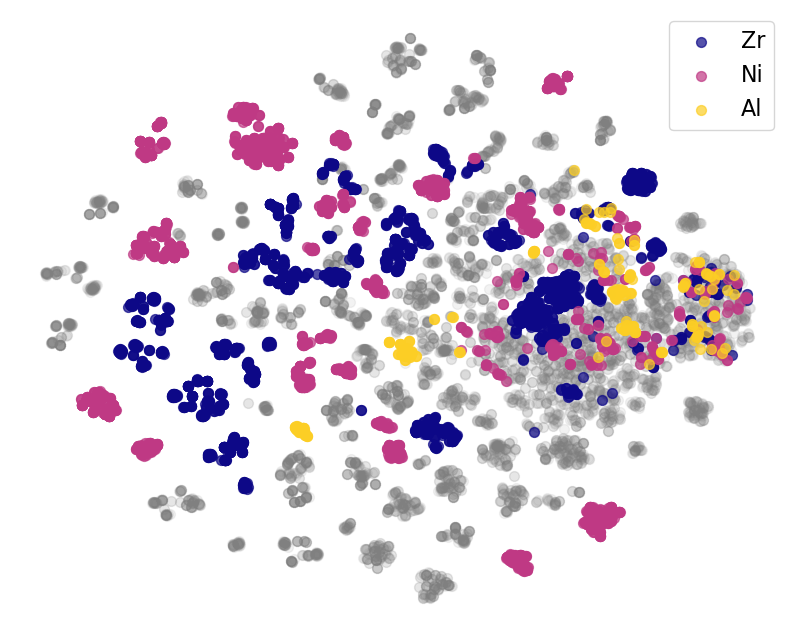

In [128]:
# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(10, 8))

# Define categories and their corresponding colors from the 'tab10' colormap
categories = ['Zr', 'Ni', 'Al']
colors = plt.cm.plasma(np.linspace(0, 0.9, len(categories)))
color_map = {category: color for category, color in zip(categories, colors)}
color_map['Others'] = 'grey'  # Set color for 'Others' as grey

# Scatter plot for 'Others' category first
subset = tsne_df[tsne_df['category'] == 'Others']
ax.scatter(subset['tsne1'], subset['tsne2'], c='grey', label='', s=50, alpha=0.1)

# Scatter plot for other categories
for category in categories:
    subset = tsne_df[tsne_df['category'] == category]
    ax.scatter(subset['tsne1'], subset['tsne2'], c=[color_map[category]], label=category, s=50, alpha=0.7)

# Adding the legend
ax.legend(fontsize=16, loc='upper right')

# Remove box frame, ticks, and labels
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()
# fig.savefig(f"cat-class/eq-emb-{model}-{enhancement}-p{perplexity}.png", dpi=300, bbox_inches='tight')
# save tsne plot
fig.savefig(f"cat-class/eq-emb-{model}.png", dpi=300, bbox_inches='tight')